In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch.optim import SGD, Adam
import random

In [2]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
device

device(type='cuda')

In [15]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 50
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [16]:
len(trainset)

40000

In [22]:
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(size=(32, 32), scale=(0.8, 1.0)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5)
])

In [23]:
aug_idx = random.sample([i for i in range(len(trainset))], 30000)
augmented_data = []

# Apply the transforms to create new images
for idx in aug_idx:
    img, label = trainset[idx]

    # Apply the augmentation transforms
    augmented_img = augmentation_transforms(img)

    # Append the augmented image to the new list
    augmented_data.append((augmented_img,label))


In [24]:
# Combine the original training set and the augmented data
combined_data = torch.utils.data.ConcatDataset([trainset, augmented_data])

# Create the data loaders
trainloader = torch.utils.data.DataLoader(combined_data, batch_size=batch_size, shuffle=True, num_workers=2)

In [25]:
len(trainloader)*batch_size

70000

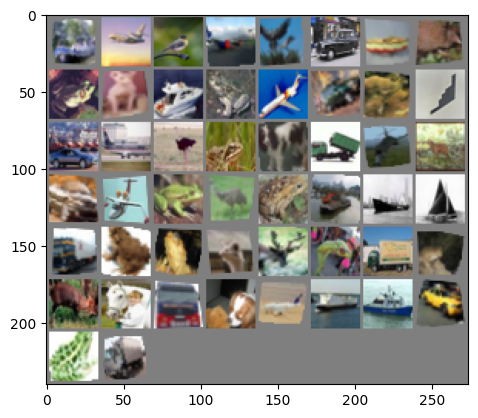

ship  plane bird  plane bird  car   ship  bird  frog  cat   ship  frog  plane car   deer  plane car   plane bird  frog  dog   truck plane deer  car   plane frog  bird  frog  ship  ship  ship  truck frog  frog  bird  deer  frog  truck frog  deer  horse truck dog   plane ship  ship  car   frog  truck


In [26]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [10]:
def train(dl, model, optimizer, n_epochs=10, valdl=None):
    L = nn.CrossEntropyLoss()
    for epoch in range(n_epochs):
        model.train()
        batch_loss = []
        val_batch_loss = []
        for x, y in dl:
            y = y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = L(out, y)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())
            model.batch_history.append(loss.item())
            
        model.history.append(np.array(batch_loss).mean())
        
        if valdl:
            with torch.no_grad():
                for valx, valy in valdl:
                    valy = valy.to(device)
                    out = model(valx)
                    loss = L(out, valy)
                    val_batch_loss.append(loss.item())
                model.val_history.append(np.array(val_batch_loss).mean())
                print(f'Epoch {len(model.history)}: Loss: {np.array(batch_loss).mean():.4f}, ValLoss: {np.array(val_batch_loss).mean():.4f}')
        else:
            print(f'Epoch {len(model.history)}: Loss: {np.array(batch_loss).mean():.4f}')
            
            
def evaluate(dl, model):
    model.eval()
    true, false = 0, 0
    for xs, ys in dl:
        xs, ys = xs.to(device), ys.to(device)
        preds = model(xs)
        preds = [pred.argmax() for pred in preds]
        for pred, y in zip(preds, ys):
            if pred == y:
                true += 1
            else:
                false += 1
    accuracy = true/(true+false)
    return accuracy 

In [32]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3) # 30
        self.batchnorm1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 64, 3) # 28
        self.batchnorm2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, 3) # 14>12
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, 3) # 10
        self.batchnorm4 = nn.BatchNorm2d(128)
        
        self.linear1 = nn.Linear(128*5*5, 128) # 5 <<
        self.linear2 = nn.Linear(128, 10)
        
        self.dropout = nn.Dropout(0.4)
        self.R = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        
    def forward(self, x):
        
        x = x.to(dtype=torch.float32)
        x = x.to(device)
        
        x = self.conv1(x) 
        x = self.R(x)
        x = self.batchnorm1(x)
        x = self.dropout(x)

        x = self.conv2(x) 
        x = self.R(x)
        x = self.batchnorm2(x)
        x = self.pool(x)
        x = self.dropout(x)
        
        x = self.conv3(x) 
        x = self.R(x)
        x = self.batchnorm3(x)
        x = self.dropout(x)

        x = self.conv4(x) 
        x = self.R(x)
        x = self.batchnorm4(x)
        x = self.pool(x)
        x = self.dropout(x)
        
        x = torch.flatten(x, 1)

        x = self.linear1(x)
        x = self.R(x)
        x = self.dropout(x)

        x = self.linear2(x)
        
        return x

In [37]:
model = Net()
model = model.to(device)

In [38]:
optimizer = Adam(model.parameters())

In [53]:
train(trainloader, model, optimizer, n_epochs=20, valdl=valloader)

Epoch 201: Loss: 0.3743, ValLoss: 0.7188
Epoch 202: Loss: 0.3702, ValLoss: 0.7288
Epoch 203: Loss: 0.3723, ValLoss: 0.7199
Epoch 204: Loss: 0.3692, ValLoss: 0.7301
Epoch 205: Loss: 0.3685, ValLoss: 0.7373
Epoch 206: Loss: 0.3676, ValLoss: 0.7139
Epoch 207: Loss: 0.3708, ValLoss: 0.7123
Epoch 208: Loss: 0.3704, ValLoss: 0.7137
Epoch 209: Loss: 0.3674, ValLoss: 0.7195
Epoch 210: Loss: 0.3741, ValLoss: 0.7152
Epoch 211: Loss: 0.3690, ValLoss: 0.6992
Epoch 212: Loss: 0.3648, ValLoss: 0.7400
Epoch 213: Loss: 0.3674, ValLoss: 0.7368
Epoch 214: Loss: 0.3690, ValLoss: 0.7047
Epoch 215: Loss: 0.3674, ValLoss: 0.7177
Epoch 216: Loss: 0.3702, ValLoss: 0.7178
Epoch 217: Loss: 0.3642, ValLoss: 0.7190
Epoch 218: Loss: 0.3690, ValLoss: 0.7368
Epoch 219: Loss: 0.3669, ValLoss: 0.7394
Epoch 220: Loss: 0.3683, ValLoss: 0.7150


In [54]:
print(evaluate(trainloader, model), evaluate(valloader, model), evaluate(testloader, model))

0.9812571428571428 0.8657 0.8585


In [66]:
torch.save(model, 'cifar10_model.pt')

In [67]:
model = torch.load('cifar10_model.pt')
model.eval()

Net4(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=3200, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (R): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [68]:
print(evaluate(trainloader, model), evaluate(valloader, model), evaluate(testloader, model))

0.9812571428571428 0.8657 0.8585
